In [374]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.spatial import distance
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
import warnings
import math

import os
os.environ['OMP_NUM_THREADS'] = '1'

from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [375]:
### Initialize data ### 
data = pd.read_csv('case1Data.txt', sep=',', skipinitialspace=True)

# Encode categorical data
data_cat = data[['C_ 1', 'C_ 2', 'C_ 3', 'C_ 4', 'C_ 5']]
data_encoded = pd.get_dummies(data_cat).astype(int)

# ??? - Hvad sker der her?
C1_dummy = pd.get_dummies(data['C_ 1'], dummy_na=True).astype(int)
NaN_col = C1_dummy.iloc[:, -1]
data_encoded.loc[NaN_col == 1, data_encoded.columns[:5]] = np.nan

# Normalize dataset
data_norm = data.copy()

scaler = StandardScaler()
data_norm.iloc[:, 1:96] = scaler.fit_transform(data_norm.iloc[:, 1:96])
scaler_filename = 'scaler_IToptimize.pkl'
joblib.dump(scaler, scaler_filename)

# Create a new dataset with the normalized and encoded data
data_pre = pd.DataFrame()
data_pre = pd.concat([data_norm.iloc[:,:96], data_encoded], axis=1)
data_pre.head()

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,C_ 4_G,C_ 4_H,C_ 4_I,C_ 4_J,C_ 4_K,C_ 5_G,C_ 5_H,C_ 5_I,C_ 5_J,C_ 5_K
0,90.685036,NaN,NaN,1.812241,0.987260,0.501513,1.181534,0.362511,0.294815,0.309919,...,0,0,0,0,1,0,0,0,1,0
1,60.844445,0.640019,-0.134319,0.470501,0.071322,1.805918,1.859452,-0.419828,NaN,0.852108,...,1,0,0,0,0,1,0,0,0,0
2,18.062345,-1.743380,-0.069207,0.117717,0.121737,0.035823,0.333980,0.494595,-0.302296,0.875596,...,0,1,0,0,0,1,0,0,0,0
3,-8.139839,2.414620,-0.563680,0.081807,0.983877,1.773029,-0.968877,-1.864873,1.020107,-1.052012,...,0,0,0,0,1,1,0,0,0,0
4,-4.994792,0.389125,NaN,1.930789,0.557851,0.334272,-0.730530,-0.561501,NaN,-0.891628,...,0,0,0,0,1,0,1,0,0,0


### KNN Imputation!

In [376]:
def ImputeWithKNN(df, K):
    KNN_imputer = KNNImputer(n_neighbors=K) 

    # Creation of new and KNN imputed dataset without y
    X = df.iloc[:, 1:]

    X_KNN_imputed = KNN_imputer.fit_transform(X)
    X_KNN_imputed = pd.DataFrame(X_KNN_imputed, columns=X.columns)
    X_KNN_imputed = pd.concat([df.iloc[:, 0], X_KNN_imputed], axis=1)
    
    return X_KNN_imputed

X_KNN_test = ImputeWithKNN(data_pre, 1)

### Iterative imputer

In [377]:
def ImputeWithIterative(df, N = 30, tol = 0.0001):
    iterative_imputer = IterativeImputer(max_iter=N, random_state=0, tol=tol, n_nearest_features=10)
    
    X = df.iloc[:, 1:]
    X_iterative_imputed = iterative_imputer.fit_transform(X)
    X_iterative_imputed = pd.DataFrame(X_iterative_imputed, columns=X.columns)
    X_iterative_imputed = pd.concat([df.iloc[:, 0], X_iterative_imputed], axis=1)
    
    return X_iterative_imputed

X_it_test = ImputeWithKNN(data_pre, 30)


In [378]:
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def impute_gmm_multidimensional(df, n_components=2, max_iter=100, covariance_type='full'):
    """
    Imputes missing values using a Gaussian Mixture Model for multidimensional data.
    
    :param df: pandas DataFrame with missing values marked as np.nan
    :param n_components: number of components for the GMM
    :param max_iter: maximum number of iterations for the EM algorithm
    :param covariance_type: string representing the type of covariance parameters to use
    :return: imputed dataset
    """
    data = df.copy()
    # Initial imputation of missing values (e.g., using mean imputation)
    imp = SimpleImputer(strategy='mean')
    data_imputed = imp.fit_transform(data)
    
    # Fit a Gaussian Mixture Model on the imputed data
    gmm = GaussianMixture(n_components=n_components, max_iter=max_iter, random_state=0, covariance_type=covariance_type)
    gmm.fit(data_imputed)
    
    # For each data point, predict the most probable component
    components = gmm.predict(data_imputed)
    
    # Use the means and covariances of the predicted components to impute missing values
    for i in range(data_imputed.shape[0]):
        missing_dims = np.isnan(data.iloc[i, :].values)
        if missing_dims.any():  # If any missing values
            comp_mean = gmm.means_[components[i]]  # Get the mean of the component
            # Impute missing values
            data_imputed[i, missing_dims] = comp_mean[missing_dims]

    
    # Create a DataFrame from the imputed data to match original format
    imputed_df = pd.DataFrame(data_imputed, columns=df.columns, index=df.index)
    
    return imputed_df


### Imputation of data

The chosen imputation is a mix of an iterative and KNN. This is done by applying both imputation on the entire dataset, however we only pick the categorical output of the KNN-imputation and the continous imputations from the iterative. Our reasoning behind this is that we want to apply the iterative for the continous part of the data, since its better at grasping non-categorical patterns, whilst the KNN approach is better suited for a categorical type of data. We've chosen to perform the imputations on the full dataset to ensure that we dont leave out importing factors in the entire dataframe. This might seem a bit contradicting, to the previous argumentation, about why doing to types of imputations, but we dont want to introduce unreasoned bias. (Eftertjek)

In [379]:
data_iterative_imputed = ImputeWithIterative(data_pre, N = 100, tol = 0.001)
data_KNN_imputed = ImputeWithKNN(data_pre, K = 1)
data_GMM_imputed = impute_gmm_multidimensional(data_pre, n_components=4, max_iter=500)

In [380]:
print(data_GMM_imputed.shape)

(100, 117)


In [381]:
data_GMM_imputed.head()

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,C_ 4_G,C_ 4_H,C_ 4_I,C_ 4_J,C_ 4_K,C_ 5_G,C_ 5_H,C_ 5_I,C_ 5_J,C_ 5_K
0,90.685036,0.125809,0.562380,1.812241,0.987260,0.501513,1.181534,0.362511,0.294815,0.309919,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,60.844445,0.640019,-0.134319,0.470501,0.071322,1.805918,1.859452,-0.419828,0.613097,0.852108,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,18.062345,-1.743380,-0.069207,0.117717,0.121737,0.035823,0.333980,0.494595,-0.302296,0.875596,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-8.139839,2.414620,-0.563680,0.081807,0.983877,1.773029,-0.968877,-1.864873,1.020107,-1.052012,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-4.994792,0.389125,0.100088,1.930789,0.557851,0.334272,-0.730530,-0.561501,0.131639,-0.891628,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [382]:
scaler = joblib.load(scaler_filename)

#data_cont = data_iterative_imputed.iloc[:, 1:96]
data_cont = data_GMM_imputed.iloc[:, 1:96]

data_cont = pd.DataFrame(scaler.inverse_transform(data_cont))
data_cat = data_GMM_imputed.iloc[:, 96:]
data_tot = pd.concat([data["y"], data_cont, data_cat], axis=1)

data_tot.columns = data_pre.columns

In [383]:
data_tot.head()

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,C_ 4_G,C_ 4_H,C_ 4_I,C_ 4_J,C_ 4_K,C_ 5_G,C_ 5_H,C_ 5_I,C_ 5_J,C_ 5_K
0,90.685036,24.555775,12.998324,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,17.174584,-2.442164,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-4.994792,25.400286,11.795737,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,15.721237,-7.341165,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [384]:
X = data_tot.iloc[:, 1:]
y = data_tot.iloc[:, 0]

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Model 

In [386]:
regr = AdaBoostRegressor(random_state=0, n_estimators=100)

n_estimators = range(50, 150, 10)
learning_rate = np.linspace(0.01, 0.5, 10)

param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate, 
    'loss' : ["linear", "square", "exponential"]
}

ada_grid = GridSearchCV(estimator = regr, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)
ada_grid.fit(X_train, y_train)
print(ada_grid.best_estimator_)

y_pred = ada_grid.best_estimator_.predict(X_train) 
RMSE_AB = math.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE = ", RMSE_AB)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


AdaBoostRegressor(learning_rate=0.33666666666666667, loss='square',
                  n_estimators=90, random_state=0)
RMSE =  10.722630304142614


In [387]:
regr2 = ElasticNet(random_state=0, max_iter=10000)

l1_ratio = np.linspace(0.1, 1, 10)
alpha = np.linspace(0.1, 1, 10)

param_grid = {
    'l1_ratio': l1_ratio,
    'alpha': alpha
}

elastic_grid = GridSearchCV(estimator = regr2, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)
elastic_grid.fit(X_train, y_train)
print(elastic_grid.best_estimator_)
y_pred = elastic_grid.best_estimator_.predict(X_train)
RMSE_EN = math.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE = ", RMSE_EN)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
ElasticNet(l1_ratio=1.0, max_iter=10000, random_state=0)
RMSE =  8.167635448115353


In [388]:
regr3 = RandomForestRegressor(random_state=0, n_estimators=100)

max_depth = range(1, 10, 10)
min_samples_split = range(2, 50, 2)
min_samples_leaf = range(1, 50, 2)

param_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

rf_grid = GridSearchCV(estimator = regr3, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_estimator_)
y_pred = rf_grid.best_estimator_.predict(X_train)
RMSE_RF = math.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE = ", RMSE_RF)


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
RandomForestRegressor(max_depth=1, min_samples_leaf=13, random_state=0)
RMSE =  35.02624308628153


In [389]:
from sklearn import svm

regr4 = svm.SVR()

C = np.linspace(0.1, 10, 10)
epsilon = np.linspace(0.1, 10, 10)
kernel = ["linear", "poly", "rbf", "sigmoid"]

param_grid = {
    'C': C,
    'epsilon': epsilon,
    'kernel': kernel
}

svm_grid = GridSearchCV(estimator = regr4, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)
svm_grid.fit(X_train, y_train)

print(svm_grid.best_estimator_)
y_pred = svm_grid.best_estimator_.predict(X_train)
RMSE_SVM = math.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE = ", RMSE_SVM)



Fitting 5 folds for each of 400 candidates, totalling 2000 fits
SVR(C=0.1, epsilon=8.9, kernel='linear')
RMSE =  18.181358688239882


In [390]:
from sklearn.linear_model import Lasso
regr6 = Lasso(random_state=0, max_iter=10000)

alpha = np.linspace(0.1, 100, 10)

param_grid = {
    'alpha': alpha
}

lasso_grid = GridSearchCV(estimator = regr6, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)
lasso_grid.fit(X_train, y_train)
print(lasso_grid.best_estimator_)
y_pred = lasso_grid.best_estimator_.predict(X_train)
RMSE_Lasso = math.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE = ", RMSE_Lasso)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Lasso(alpha=11.200000000000001, max_iter=10000, random_state=0)
RMSE =  21.177147975519983


In [391]:
from sklearn.linear_model import Ridge
regr7 = Ridge(random_state=0, max_iter=10000)

alpha = np.linspace(0.1, 500, 100)

param_grid = {
    'alpha': alpha
}

ridge_grid = GridSearchCV(estimator = regr7, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)
ridge_grid.fit(X_train, y_train)
print(ridge_grid.best_estimator_)
y_pred = ridge_grid.best_estimator_.predict(X_train)
RMSE_Ridge = math.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE = ", RMSE_Ridge)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Ridge(alpha=121.28787878787878, max_iter=10000, random_state=0)
RMSE =  12.117519241578892


In [392]:
# Summary of all models

print("RMSE AdaBoost: ", RMSE_AB)
print("RMSE ElasticNet: ", RMSE_EN)
print("RMSE RandomForest: ", RMSE_RF)
print("RMSE Lasso: ", RMSE_Lasso)
print("RMSE Ridge: ", RMSE_Ridge)

# The best model is the one with the lowest RMSE
print("The best model is : ", min(RMSE_AB, RMSE_EN, RMSE_RF, RMSE_SVM, RMSE_Lasso, RMSE_Ridge))

RMSE AdaBoost:  10.722630304142614
RMSE ElasticNet:  8.167635448115353
RMSE RandomForest:  35.02624308628153
RMSE Lasso:  21.177147975519983
RMSE Ridge:  12.117519241578892
The best model is :  8.167635448115353


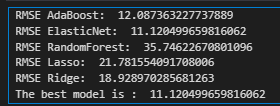

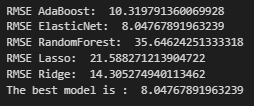

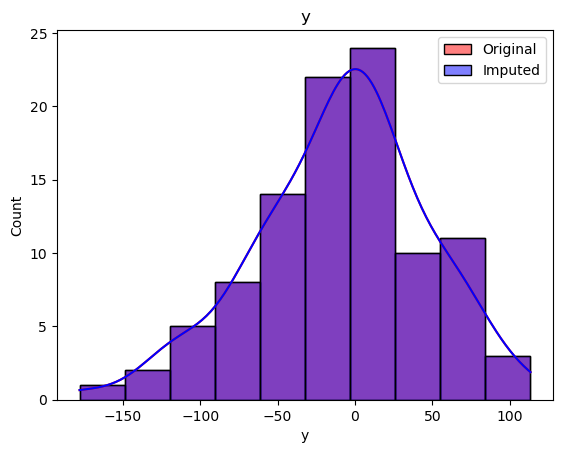

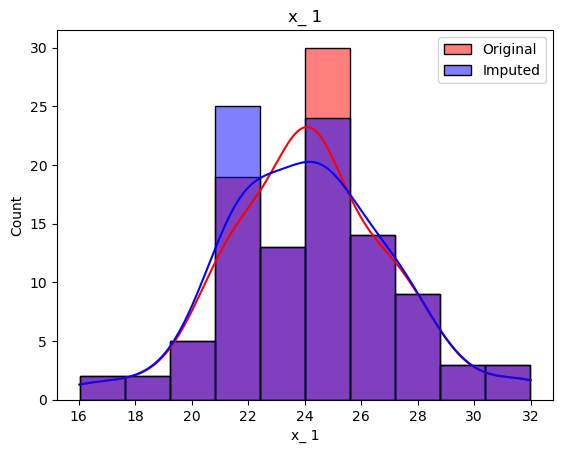

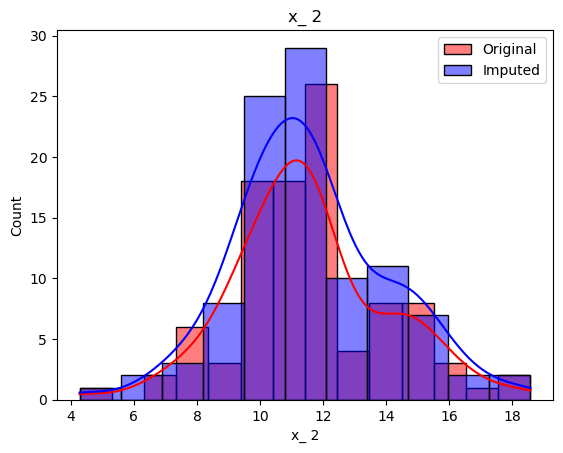

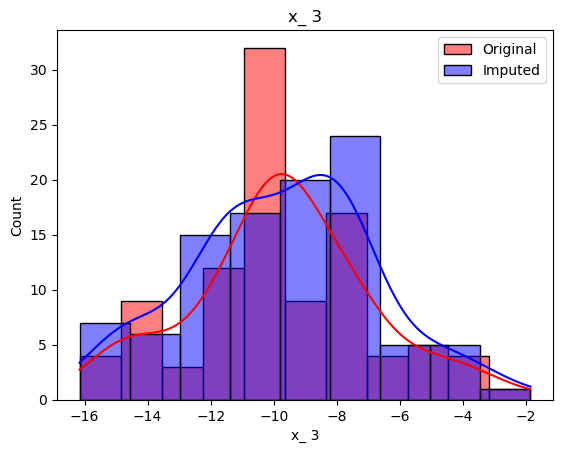

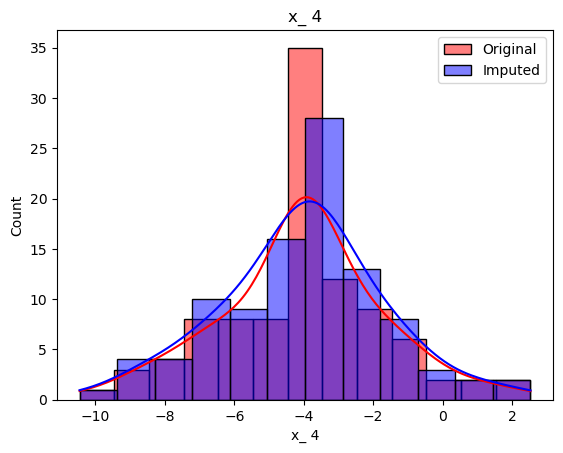

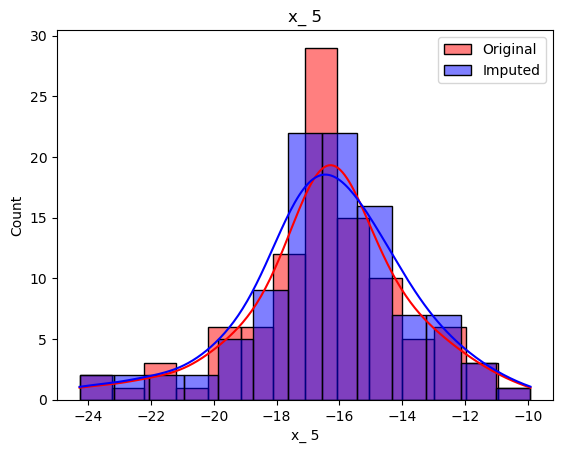

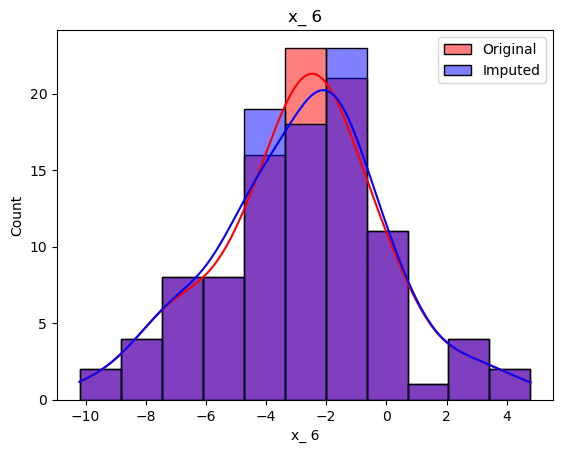

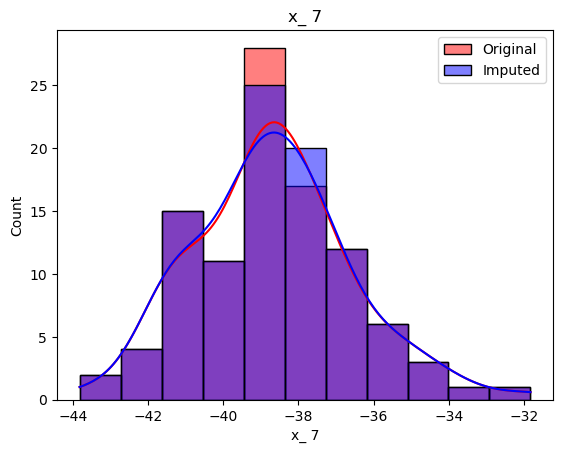

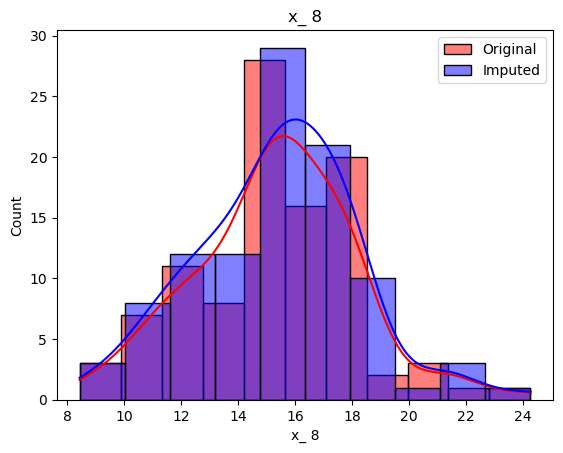

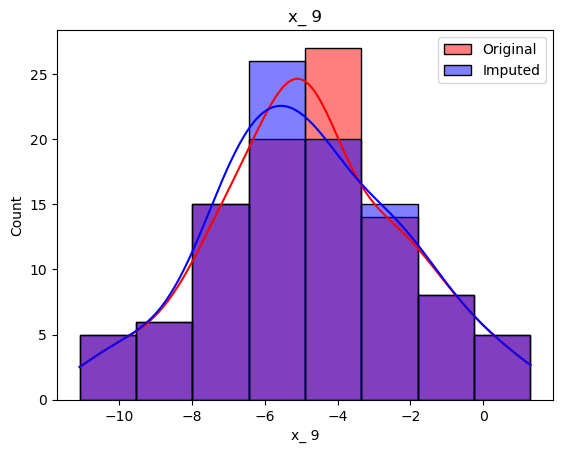

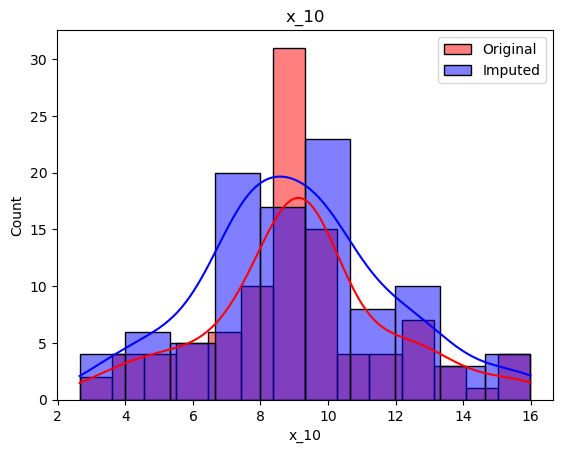

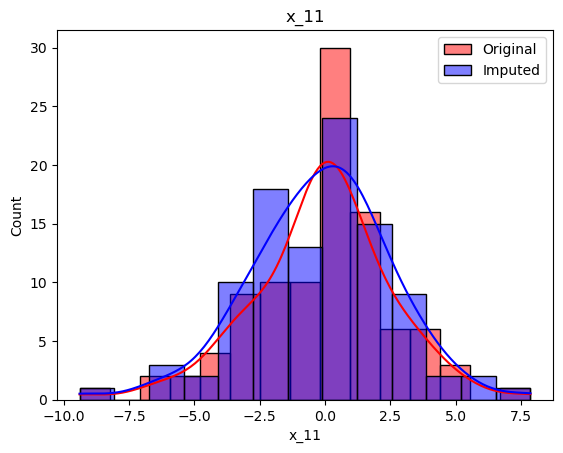

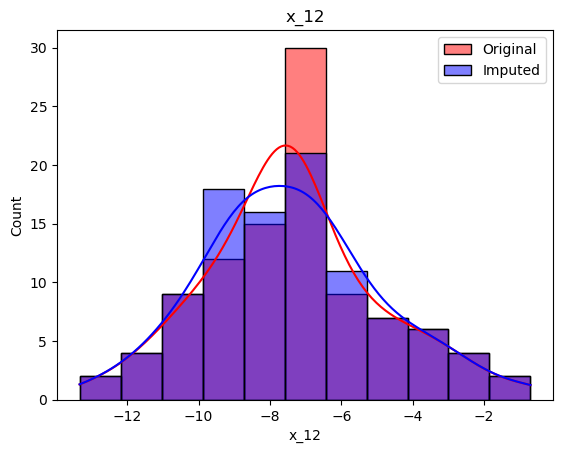

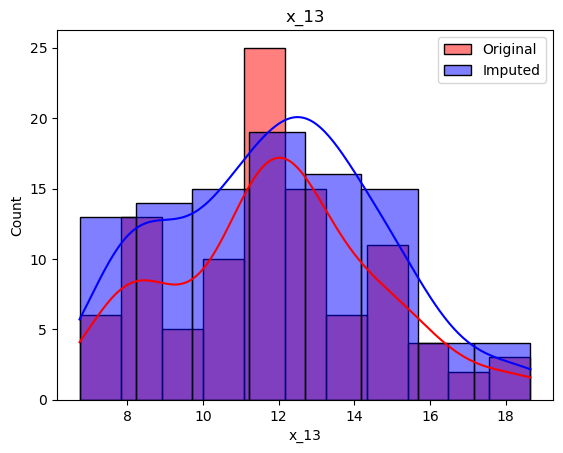

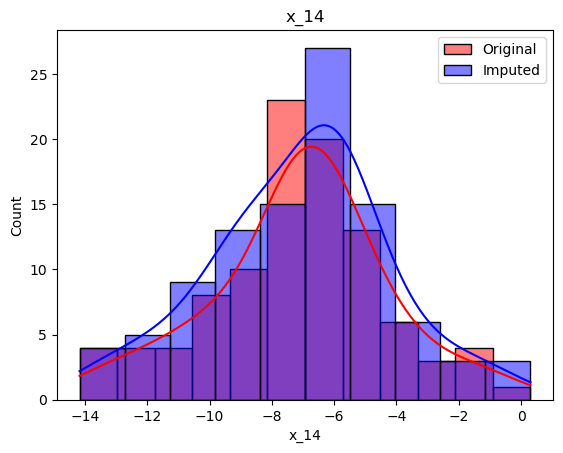

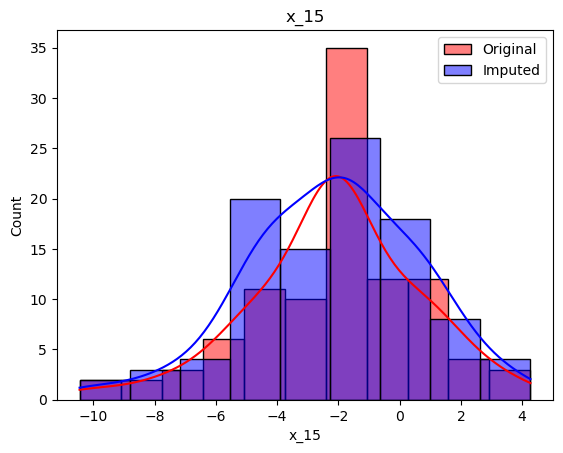

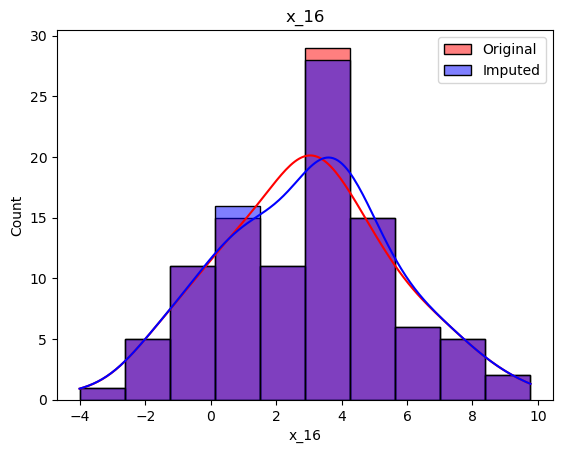

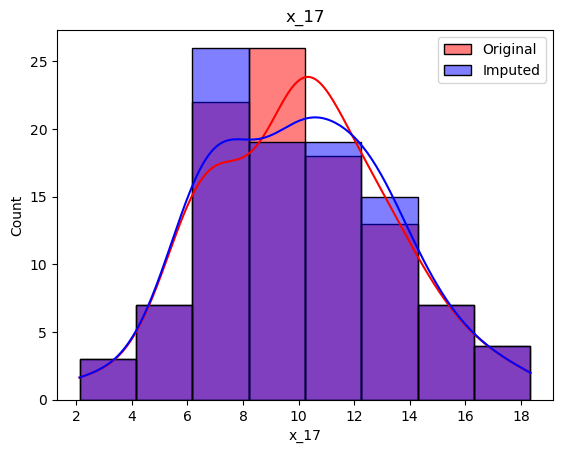

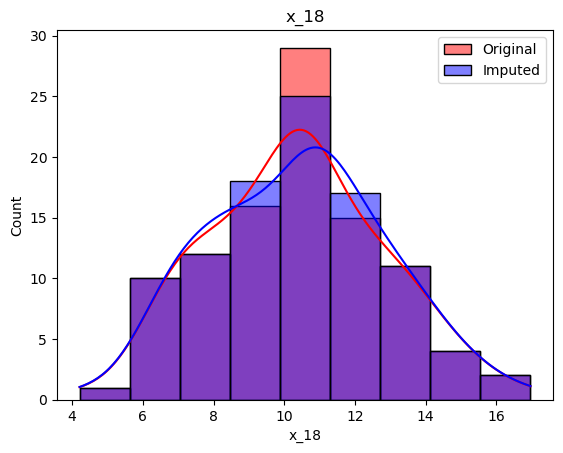

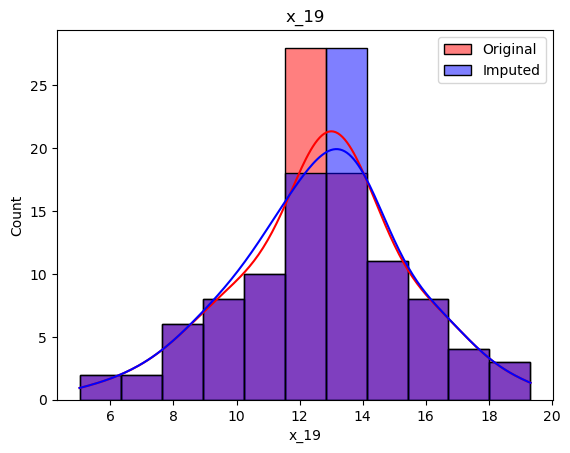

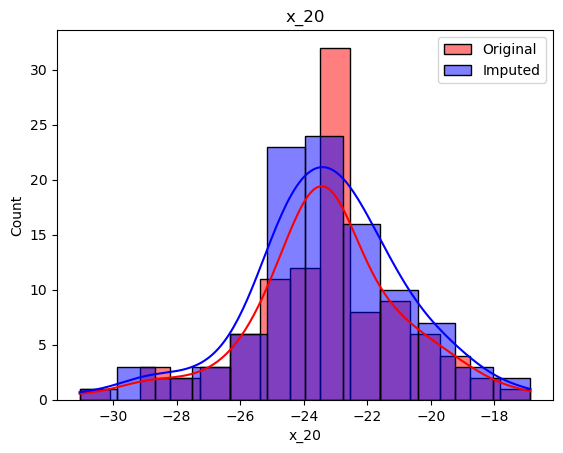

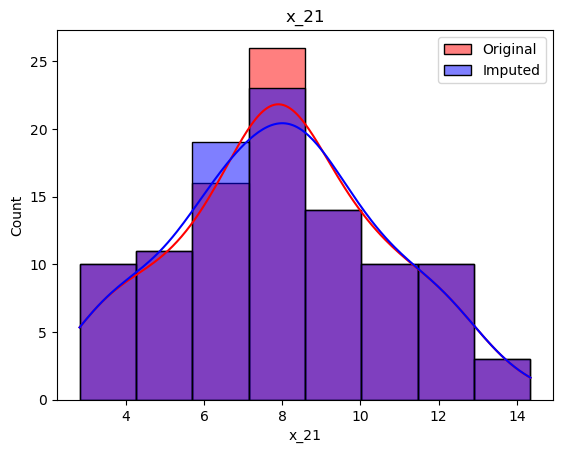

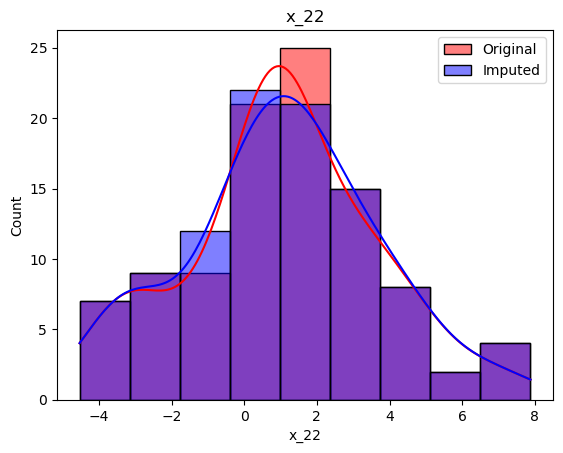

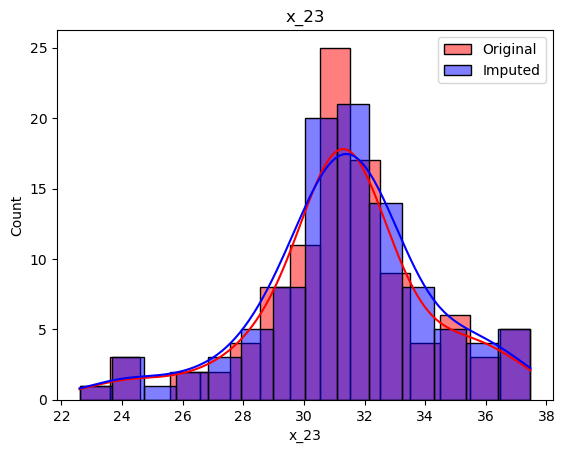

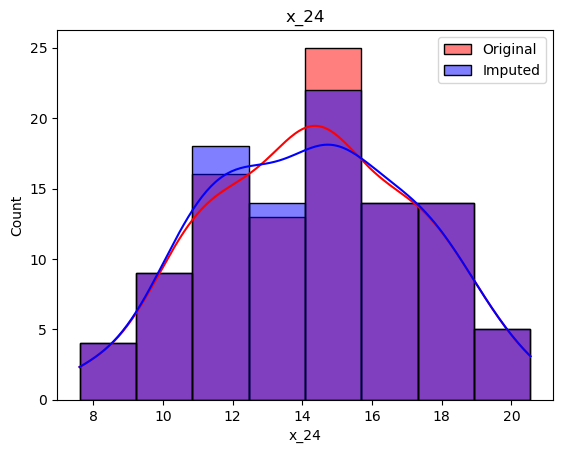

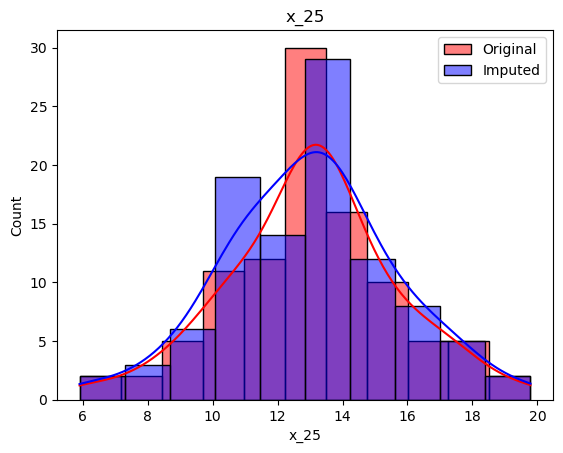

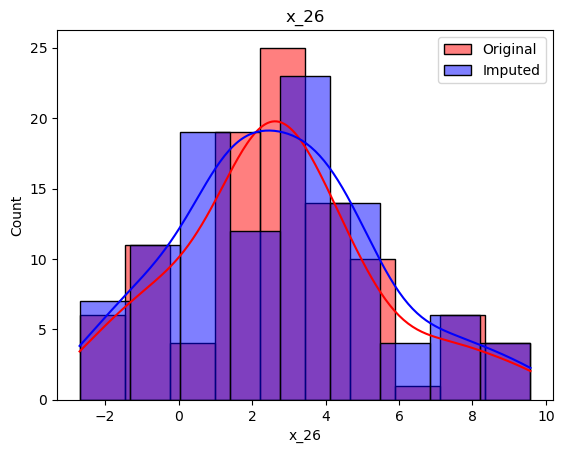

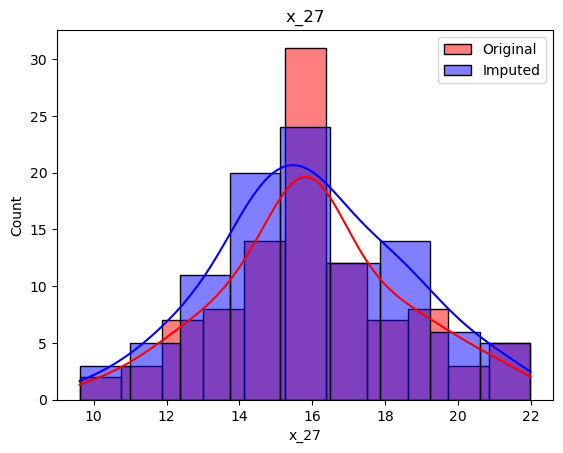

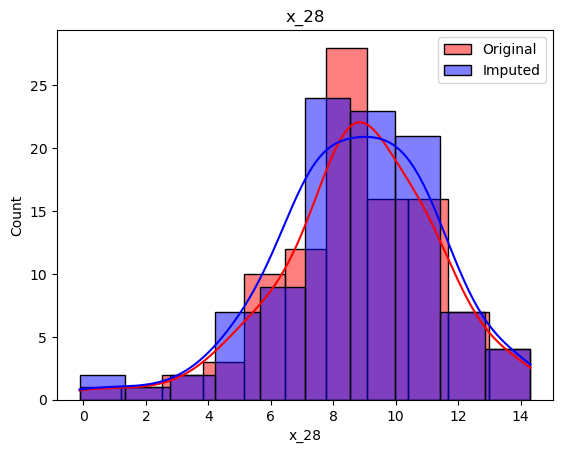

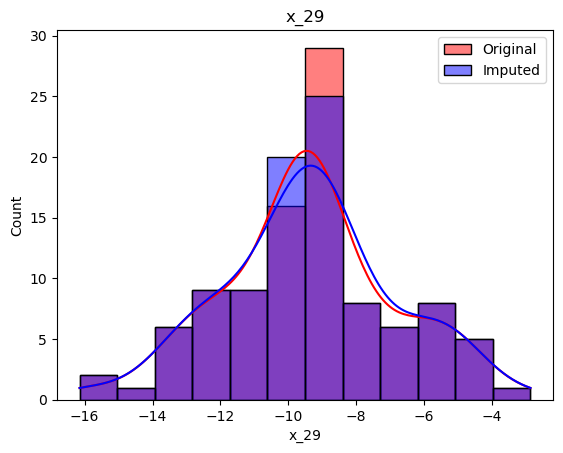

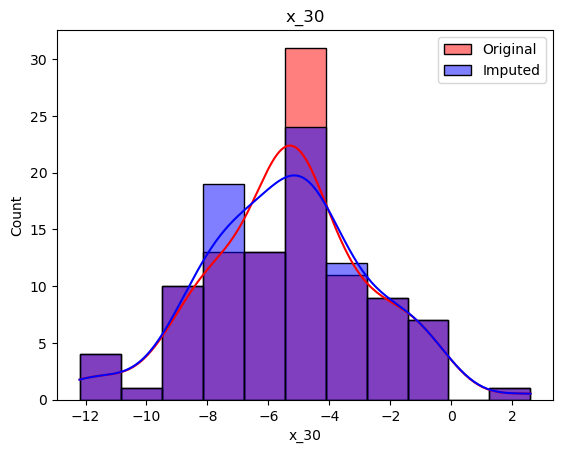

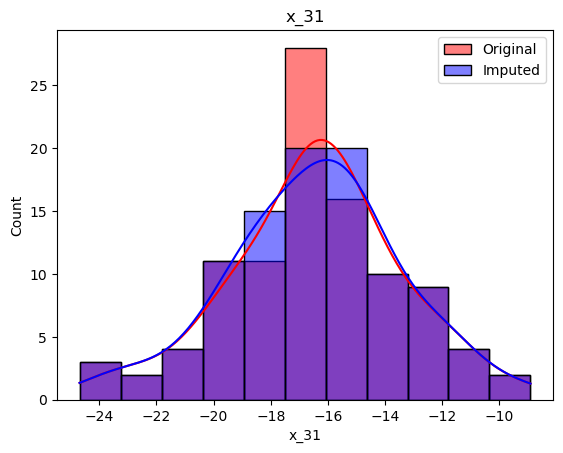

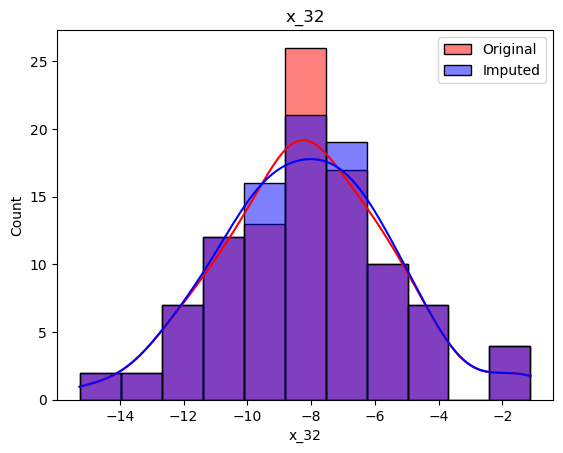

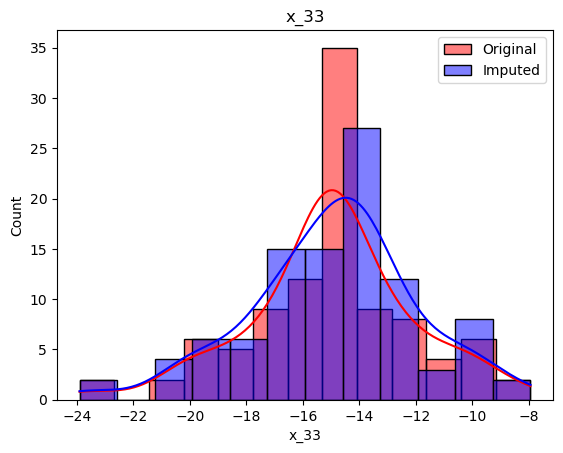

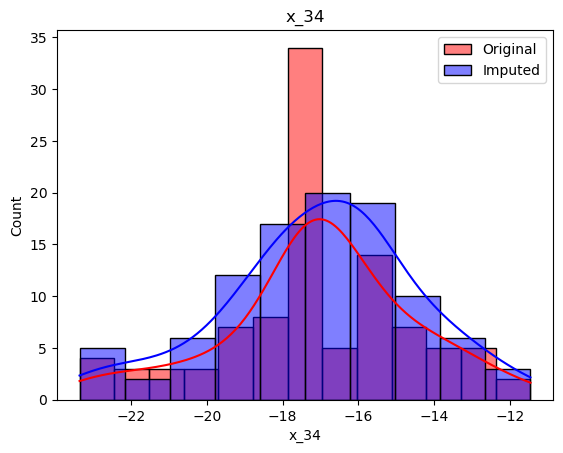

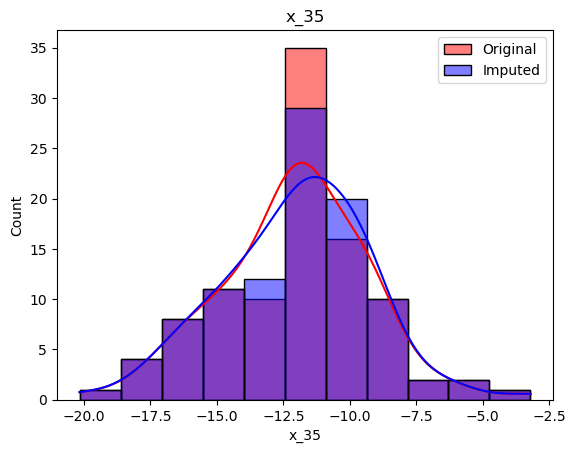

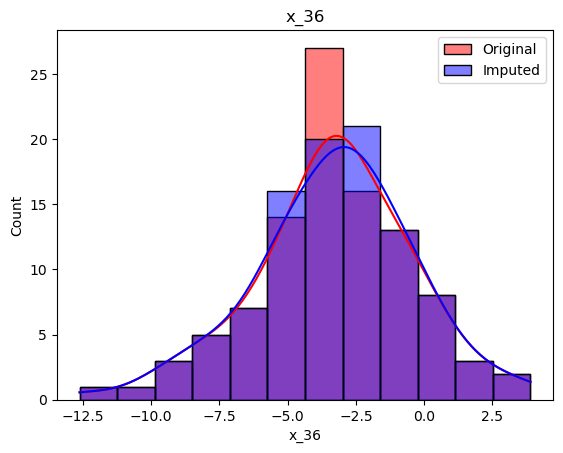

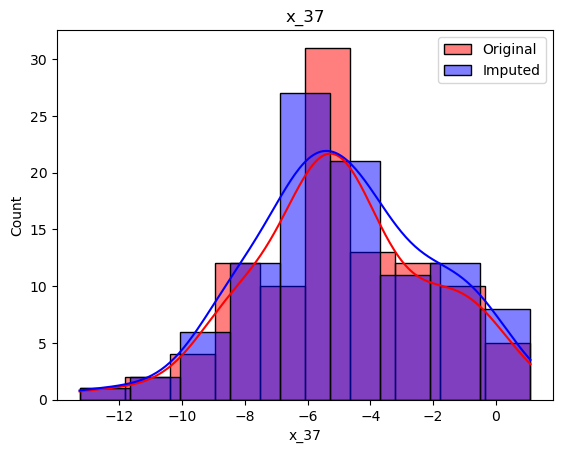

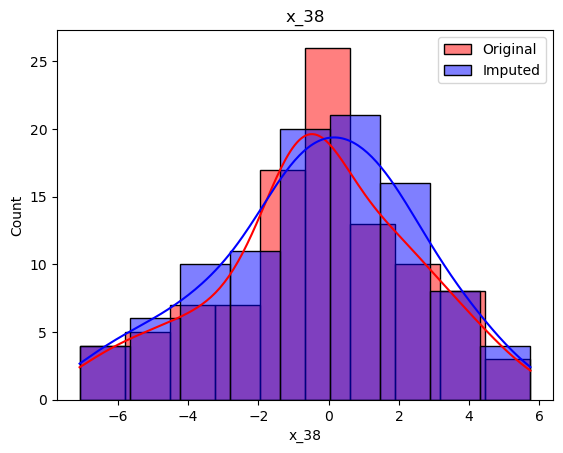

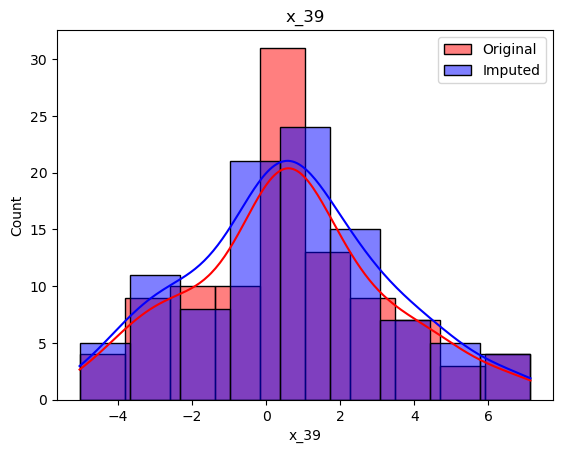

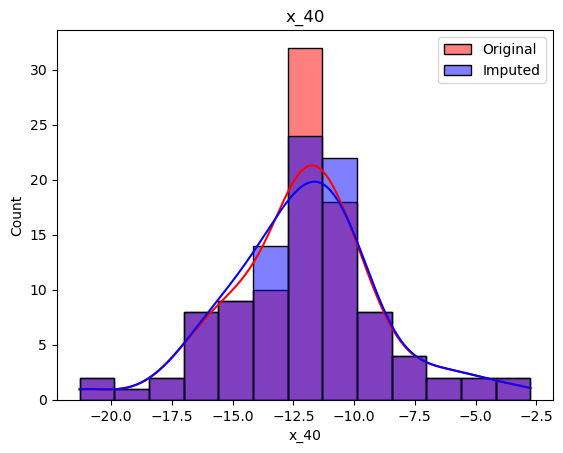

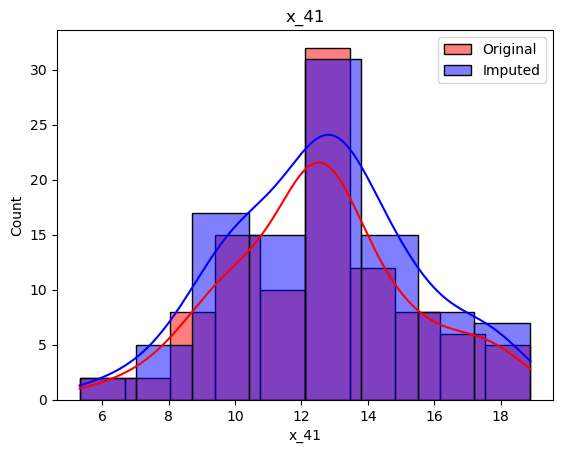

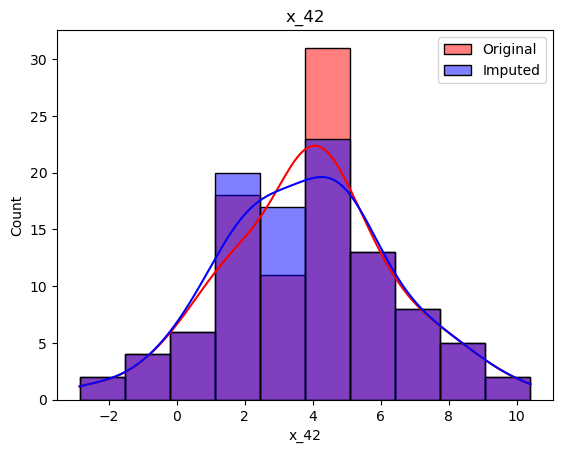

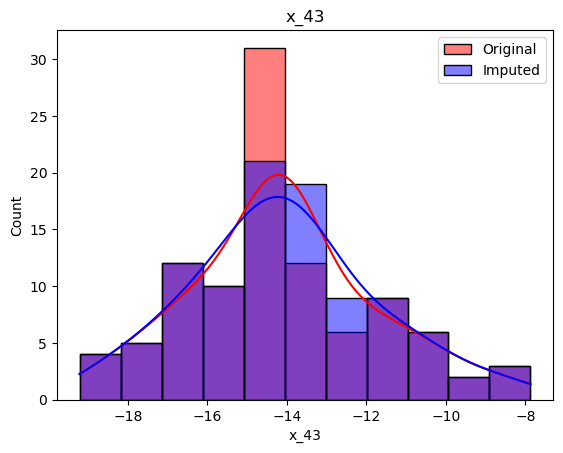

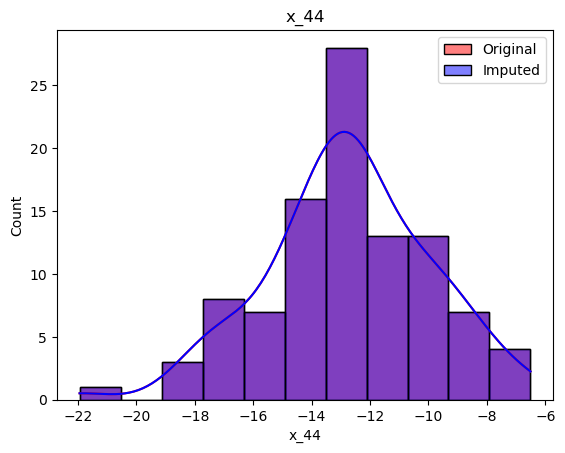

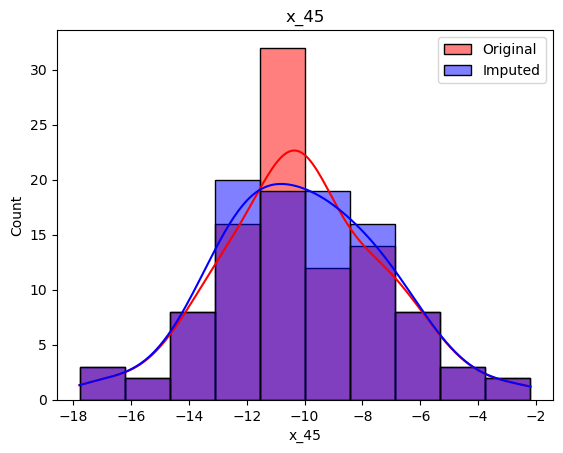

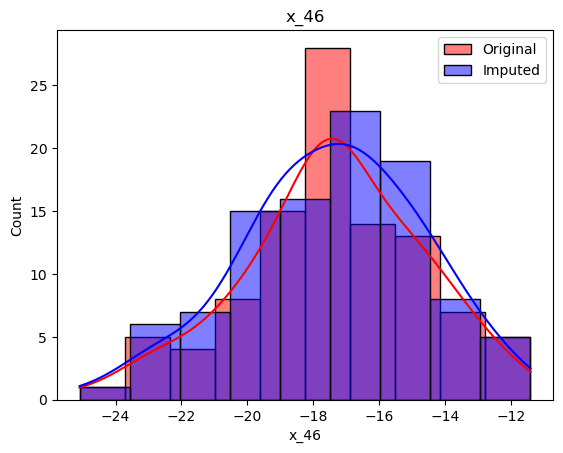

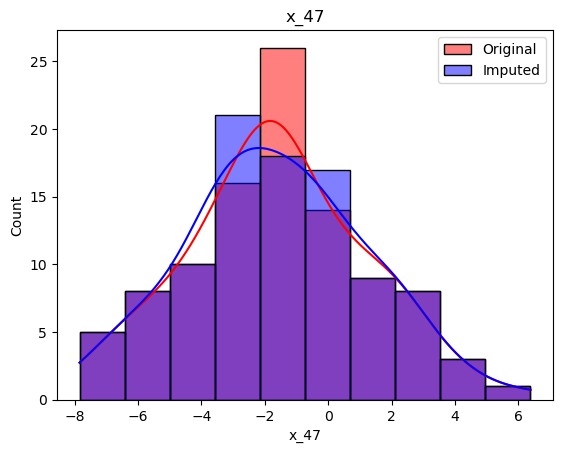

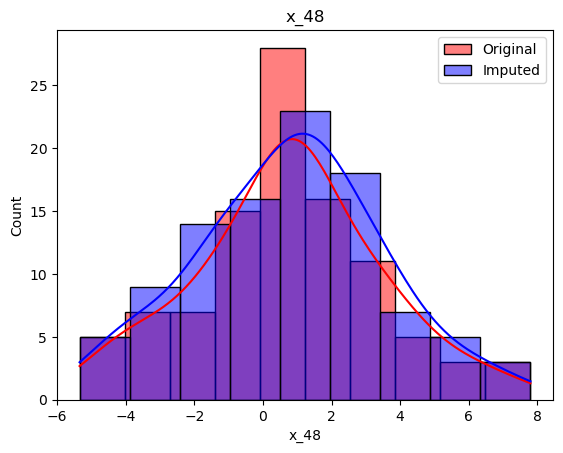

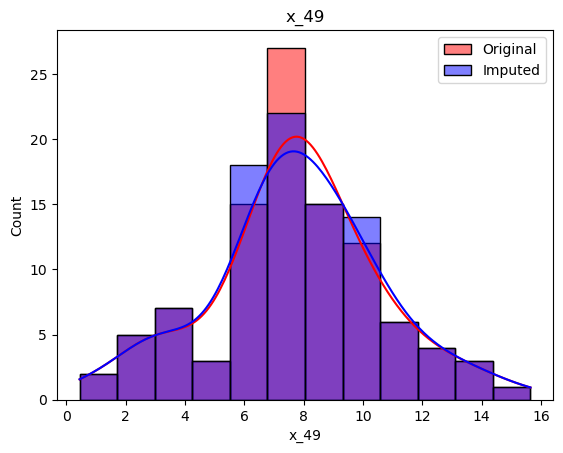

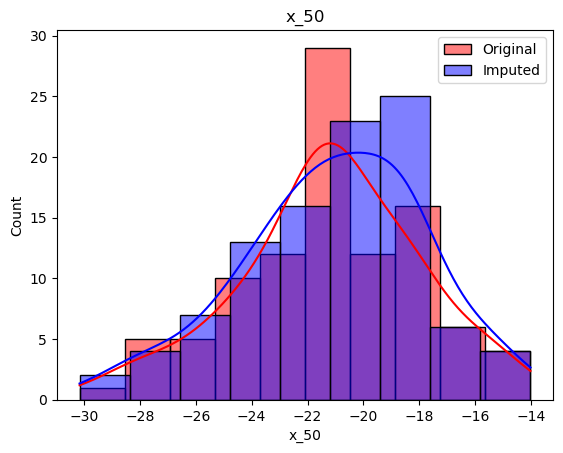

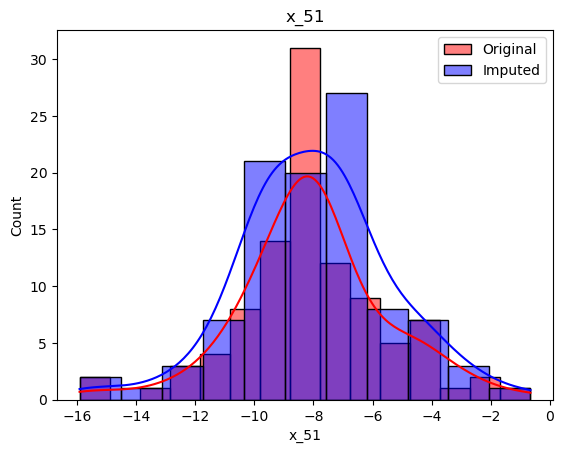

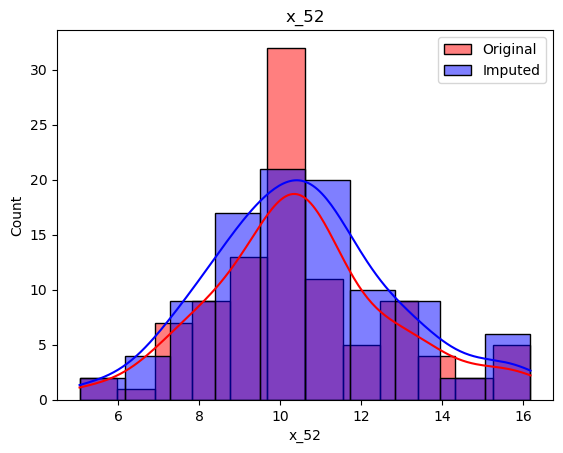

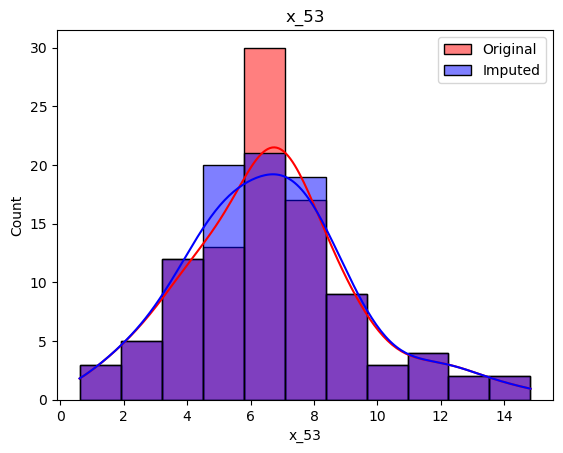

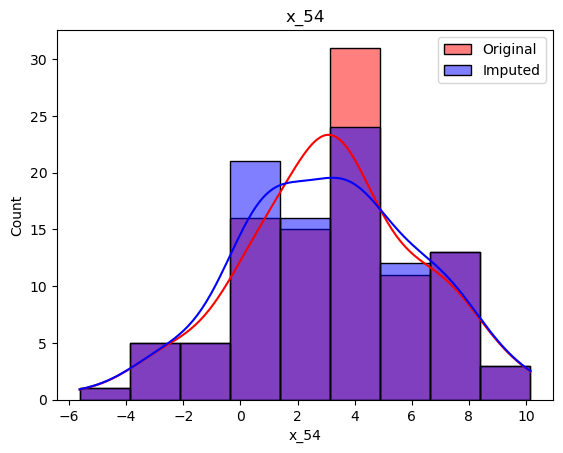

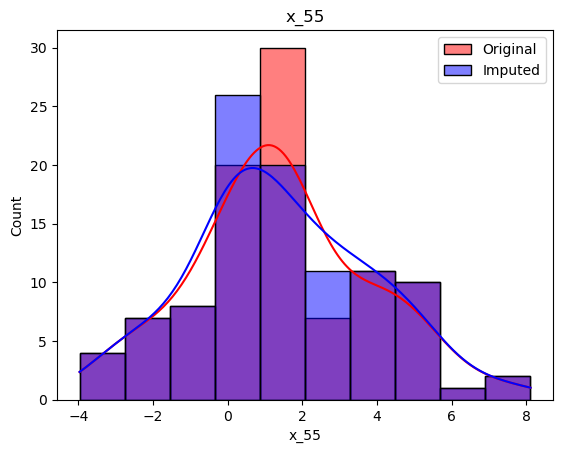

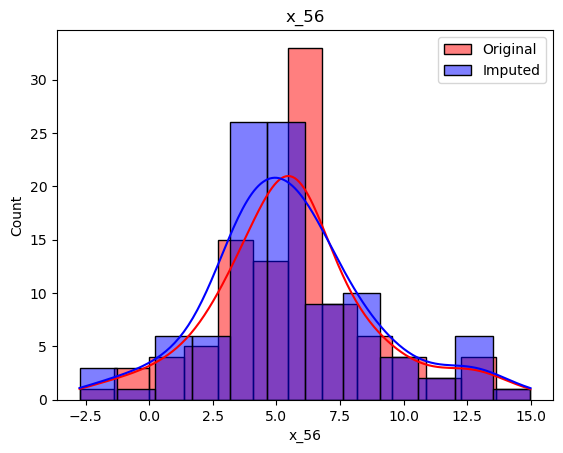

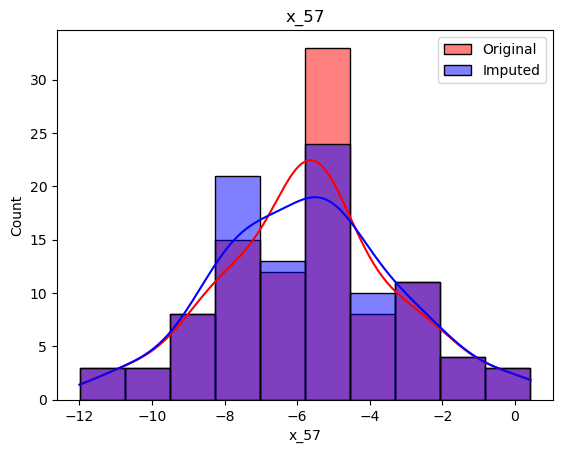

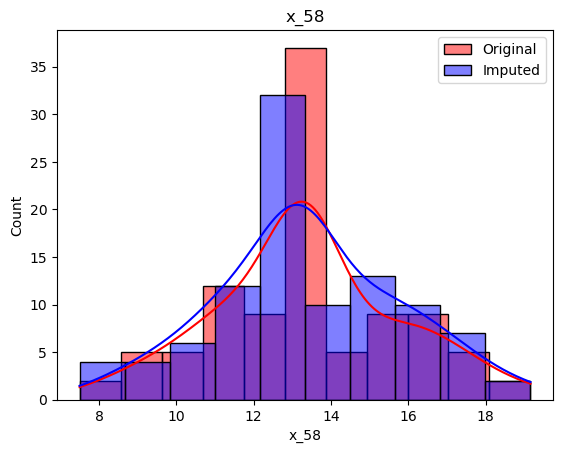

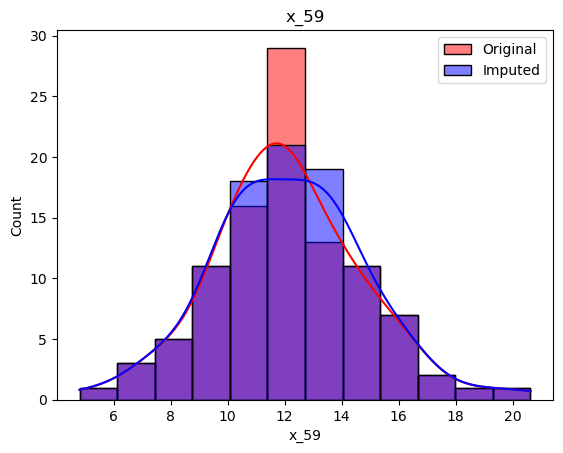

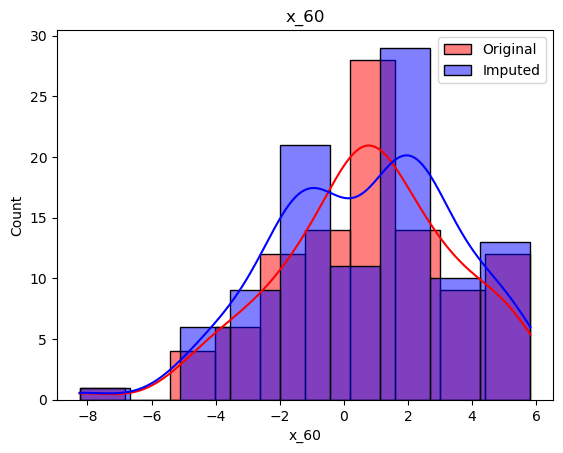

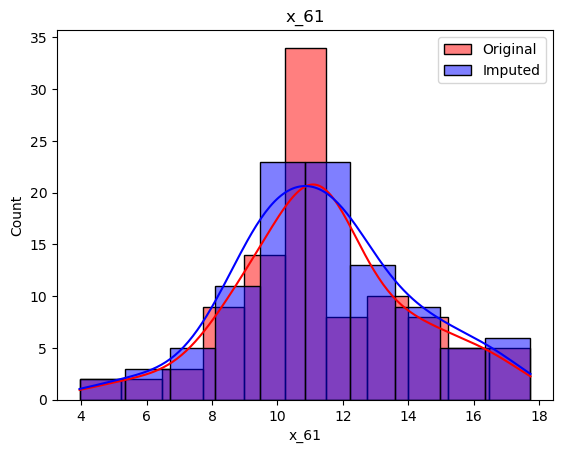

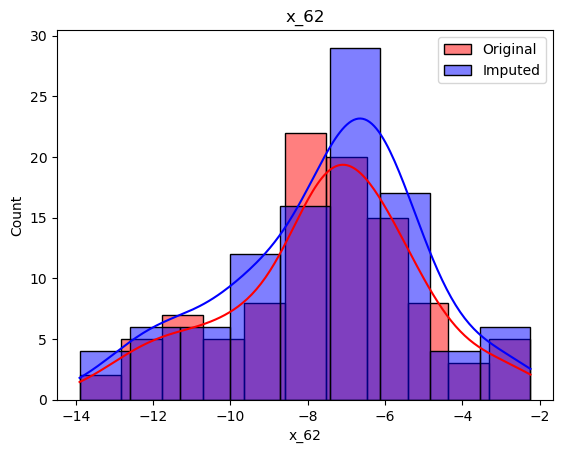

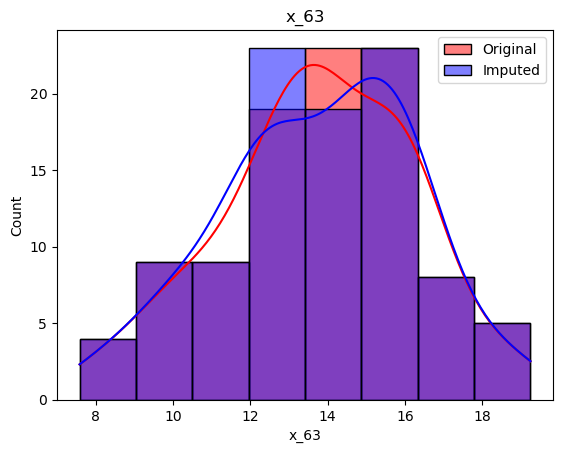

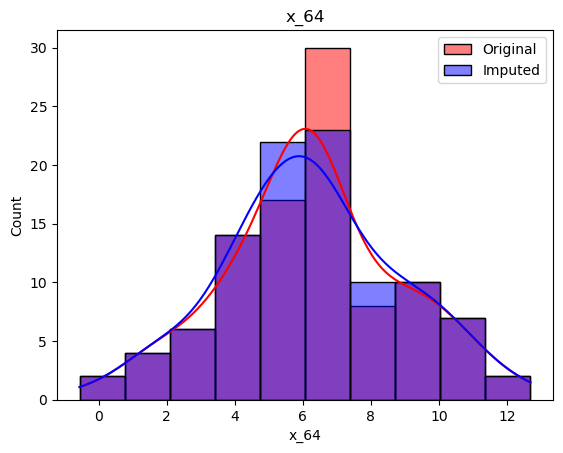

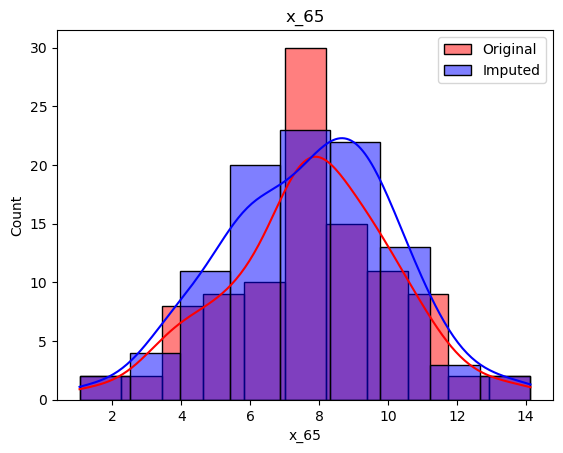

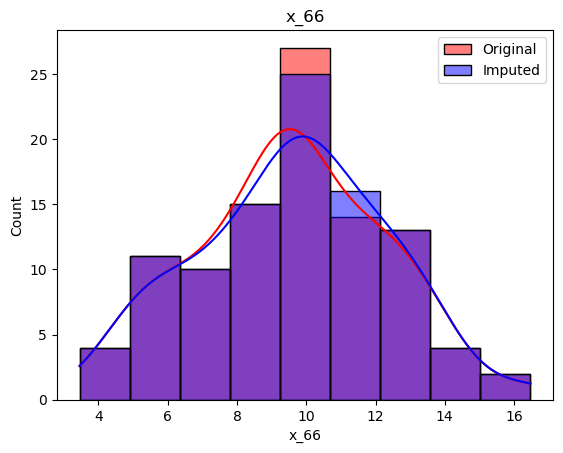

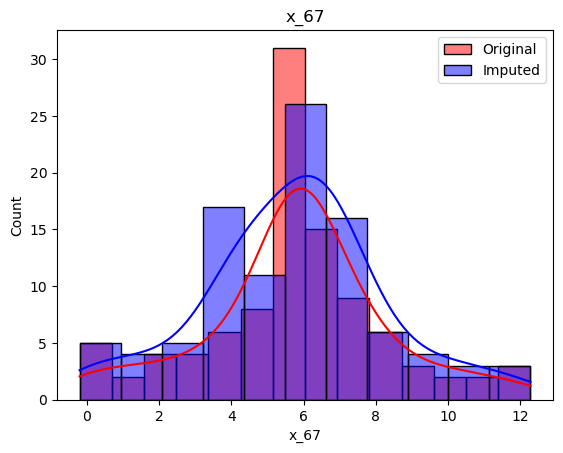

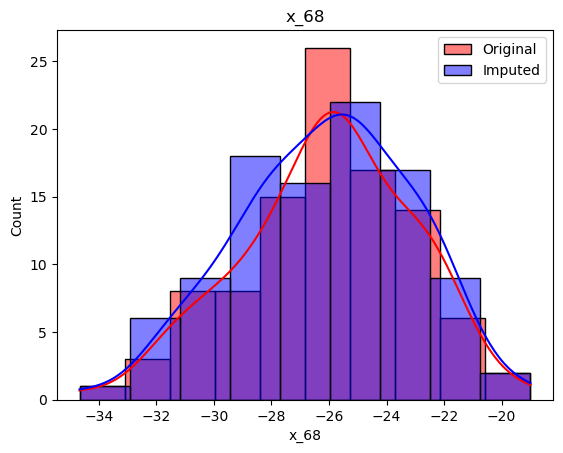

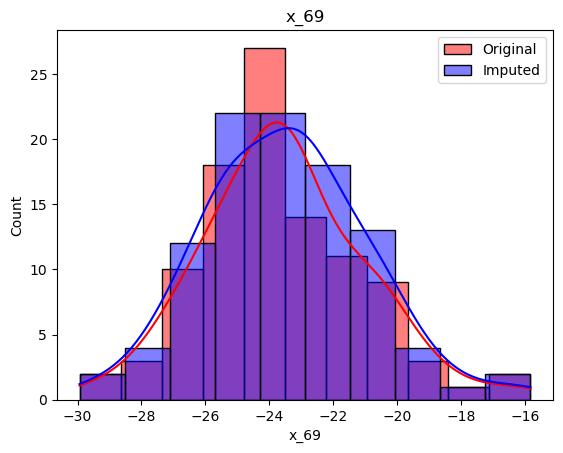

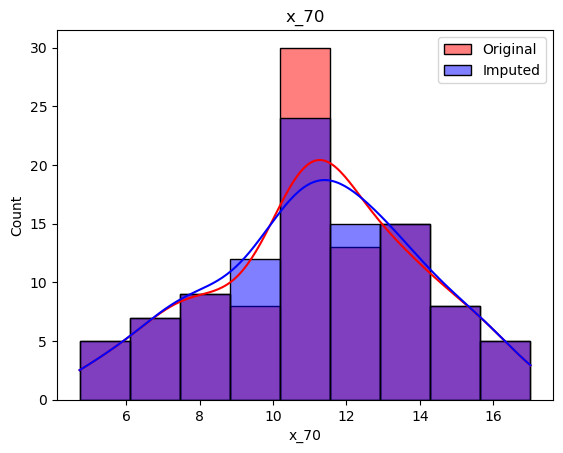

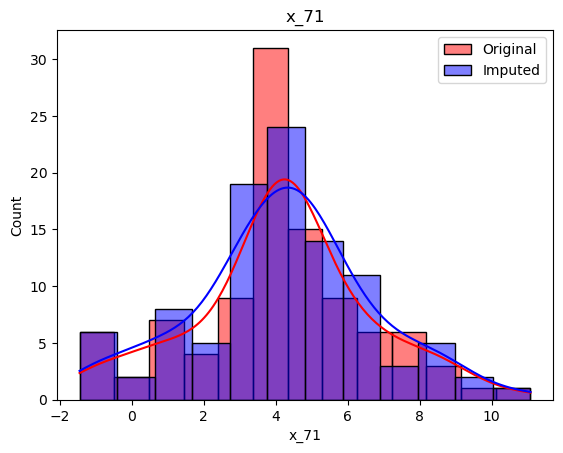

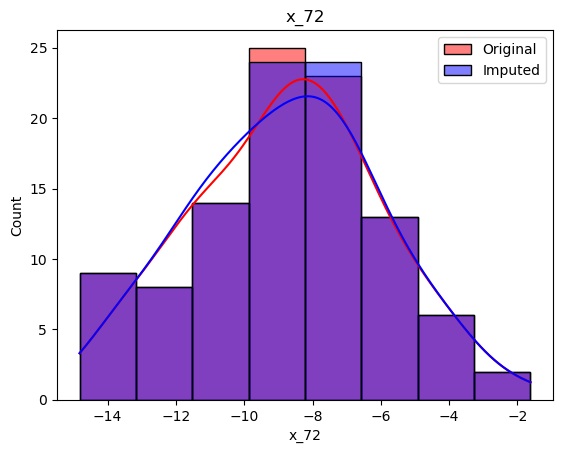

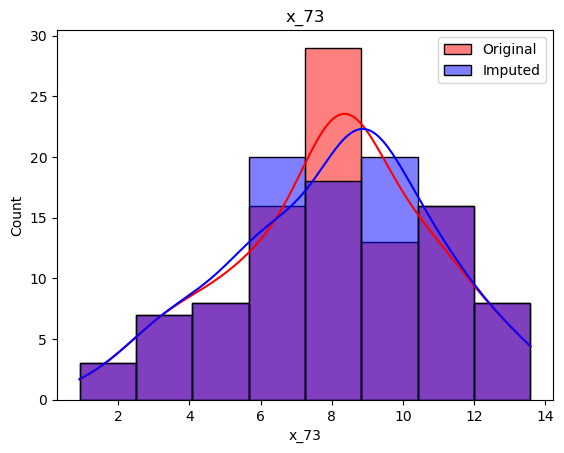

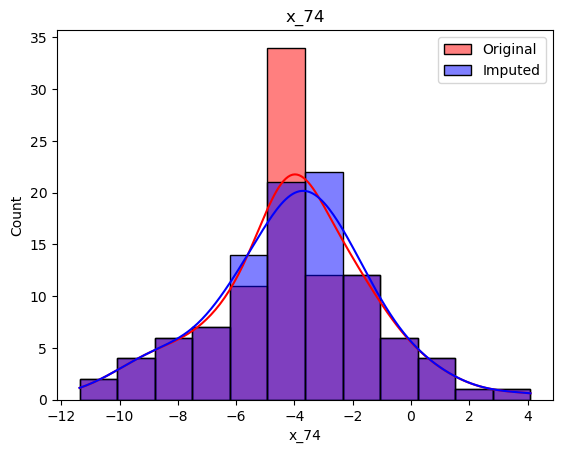

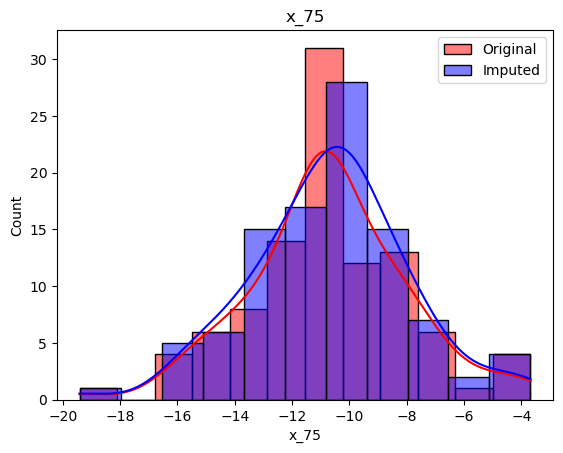

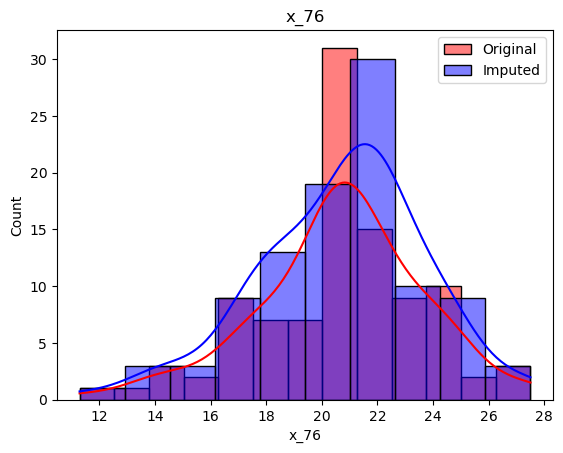

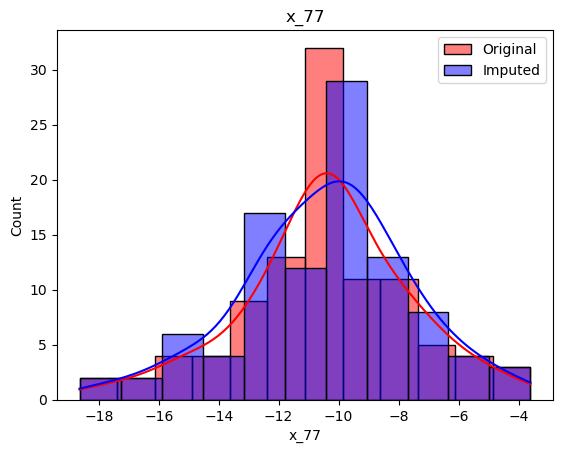

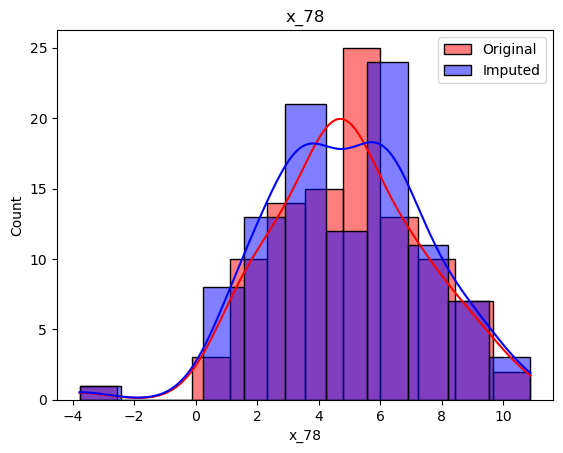

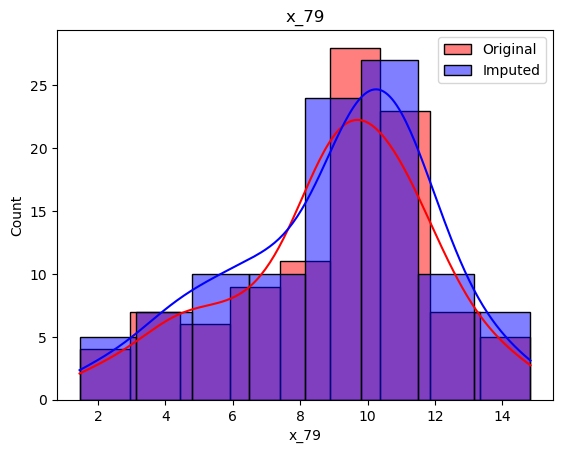

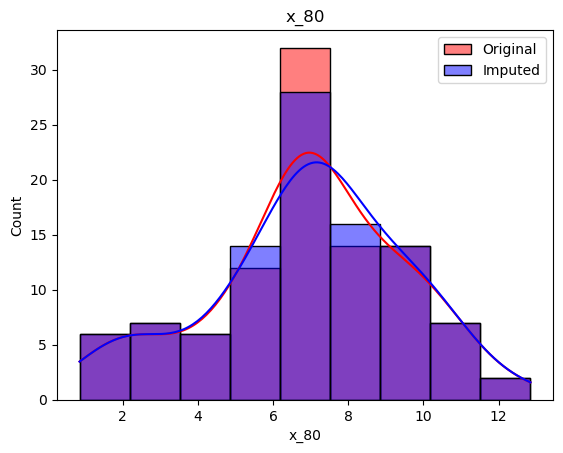

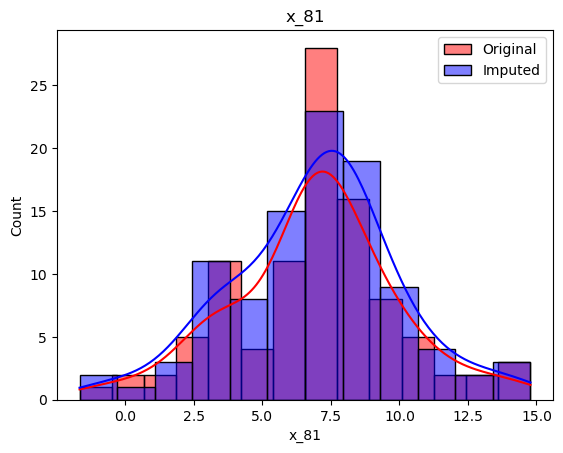

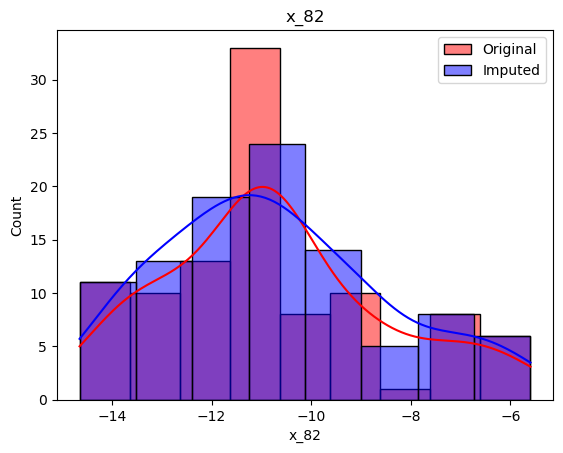

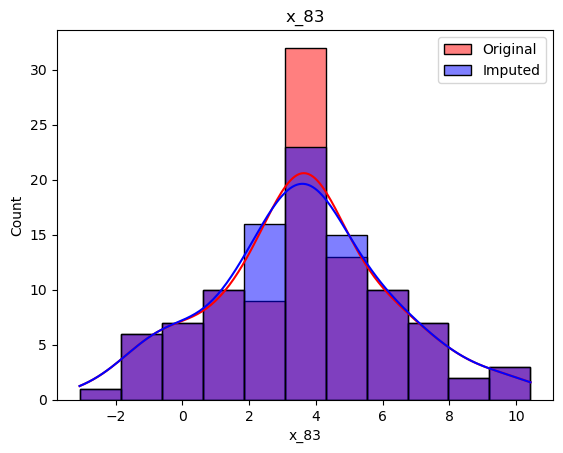

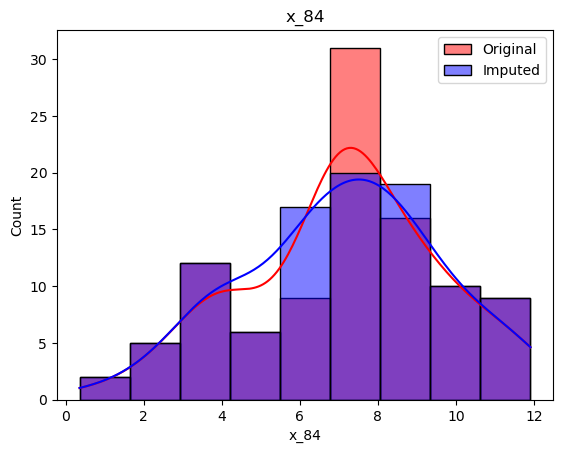

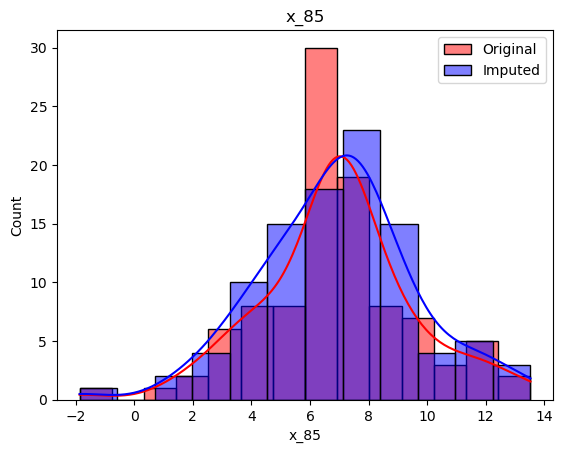

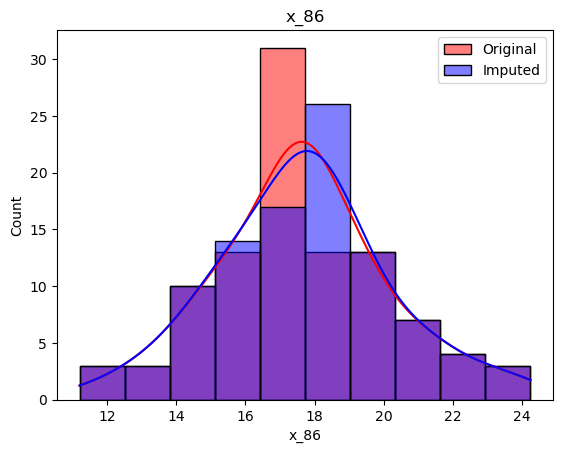

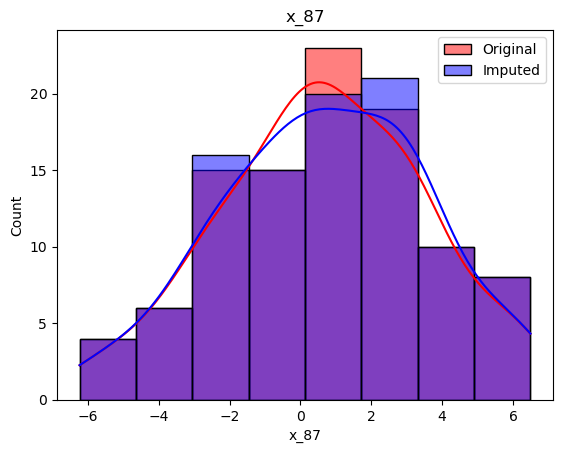

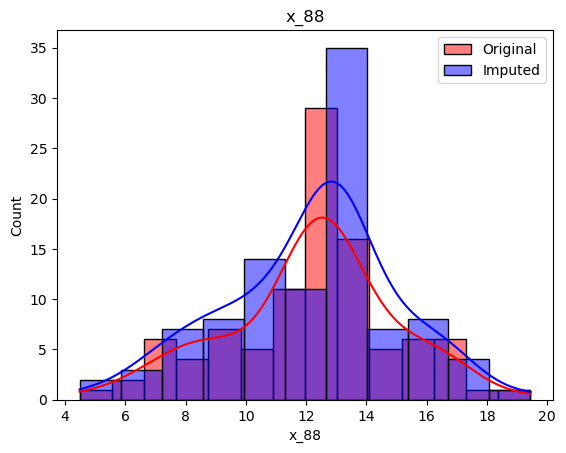

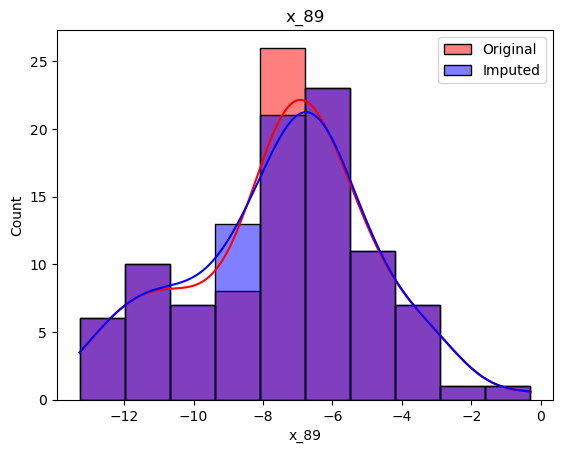

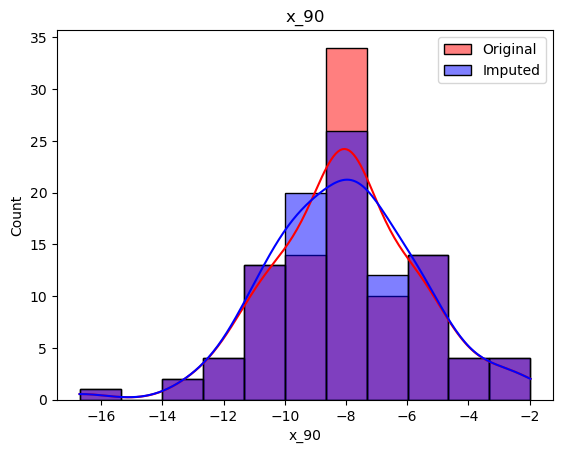

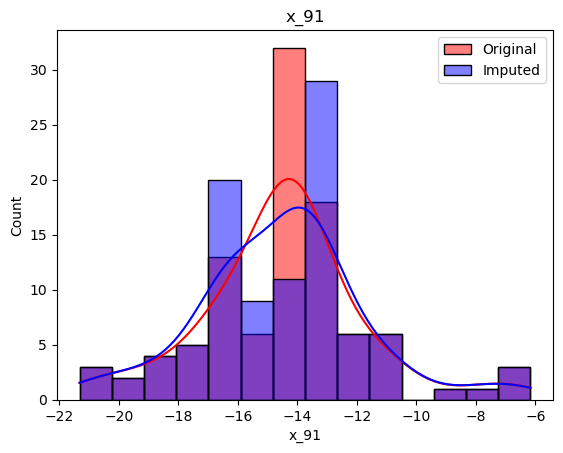

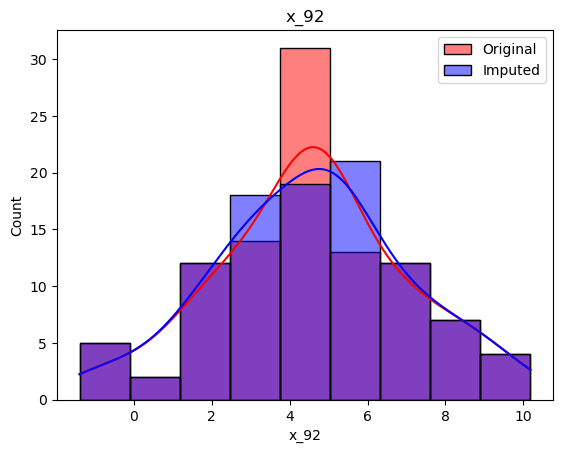

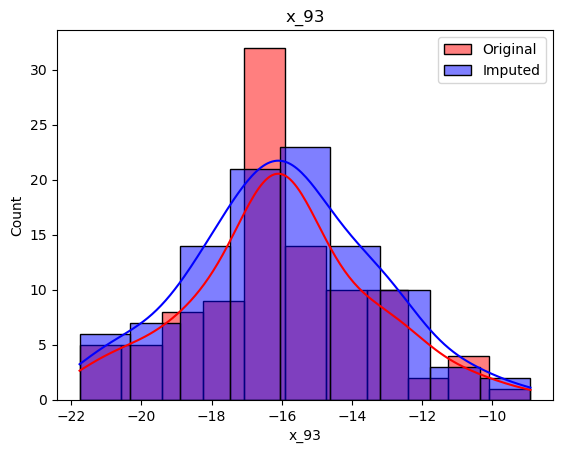

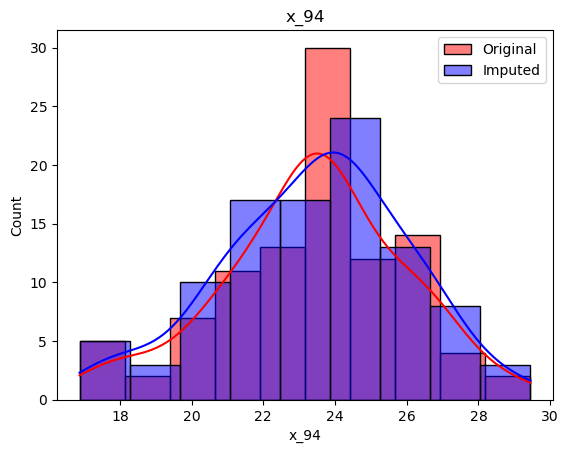

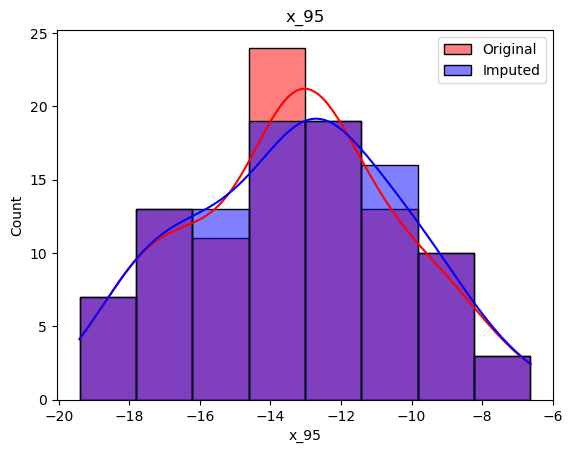

In [393]:
for col in data_tot.columns[:96]:
    plt.figure()
    plt.title(col)

    temp = data[col].fillna(data[col].mean(), inplace=False)
    sns.histplot(temp, kde=True, color='red', label="Original", alpha = 0.5)
    sns.histplot(data_tot[col], kde=True, color='blue', label="Imputed", alpha = 0.5)
    plt.legend()
    plt.show()

In [394]:
warnings.filterwarnings('ignore')

count_orgi = data_cat['C_ 1'].value_counts(dropna=True)
count_knn = data_tot.iloc[:, 96:101].sum()


per_orgi = (count_orgi / count_orgi.sum() * 100).sort_index()
per_knn  = (count_knn / count_knn.sum() * 100).sort_index()


index = np.arange(len(per_orgi))
bar_width = 0.15

plt.figure(figsize=(10, 4))

plt.bar(index, per_orgi, bar_width, color='blue', alpha=0.7, label='orgi')
plt.bar(index + bar_width, per_knn, bar_width, color='orange', alpha=0.7, label='knn')

plt.title('Comparison of Percentages')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.xticks(index + bar_width / 2, per_orgi.index)
plt.legend()
plt.tight_layout()
plt.show()

print("Sum of percentages for count_orginal:", per_orgi.sum())
print("Sum of percentages for count_uni:", per_orgi.sum())

plt.show()

KeyError: 'C_ 1'